In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os

In [2]:
# Set random seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)

In [3]:
# Load and prepare data
data = load_iris()
X = data.data
y = data.target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
X_train_t = torch.FloatTensor(X_train_scaled)
X_test_t = torch.FloatTensor(X_test_scaled)
y_train_t = torch.LongTensor(y_train)
y_test_t = torch.LongTensor(y_test)

In [7]:
class ANN(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[64, 32], num_classes=3):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def copy_weights_from(self, other_model):
        self.load_state_dict(other_model.state_dict())

In [8]:
def train_model_with_shuffled_data(model, X_train, y_train, epochs=50, batch_size=32, lr=0.001):
    # Create shuffled dataset
    shuffle_idx = torch.randperm(len(X_train))
    X_shuffled = X_train[shuffle_idx]
    y_shuffled = y_train[shuffle_idx]
    
    # Create DataLoader
    dataset = TensorDataset(X_shuffled, y_shuffled)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    return model

In [9]:
# Initialize two models with IDENTICAL weights
print("Initializing models with identical weights...")
model1 = ANN()
model2 = ANN()

Initializing models with identical weights...


In [10]:
initial_weights = model1.state_dict()
torch.save(initial_weights, 'initial_weights.pth')

# Ensure model2 has exact same weights
model2.load_state_dict(initial_weights)

<All keys matched successfully>

In [11]:
for (name1, param1), (name2, param2) in zip(model1.named_parameters(), model2.named_parameters()):
    assert torch.equal(param1, param2), f"Initial weights not identical for {name1}"
print("✓ Initial weights verified as identical")


✓ Initial weights verified as identical


In [12]:
print("\nTraining Model 1...")
model1 = train_model_with_shuffled_data(model1, X_train_t, y_train_t, epochs=50)

print("Training Model 2 (with different shuffling)...")
model2 = train_model_with_shuffled_data(model2, X_train_t, y_train_t, epochs=50)


Training Model 1...
Training Model 2 (with different shuffling)...


In [13]:
def get_all_activations(model, X_data):
    activations = {}
    hooks = []
    
    def get_activation(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook
    
    # Register hooks
    hooks.append(model.fc1.register_forward_hook(get_activation('fc1')))
    hooks.append(model.fc2.register_forward_hook(get_activation('fc2')))
    hooks.append(model.fc3.register_forward_hook(get_activation('fc3')))
    
    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(X_data)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return activations

In [14]:
# Collect activations for both models on the SAME test data
print("\nCollecting activations from both models...")
activations1 = get_all_activations(model1, X_test_t)
activations2 = get_all_activations(model2, X_test_t)


Analyzing with correct formula...


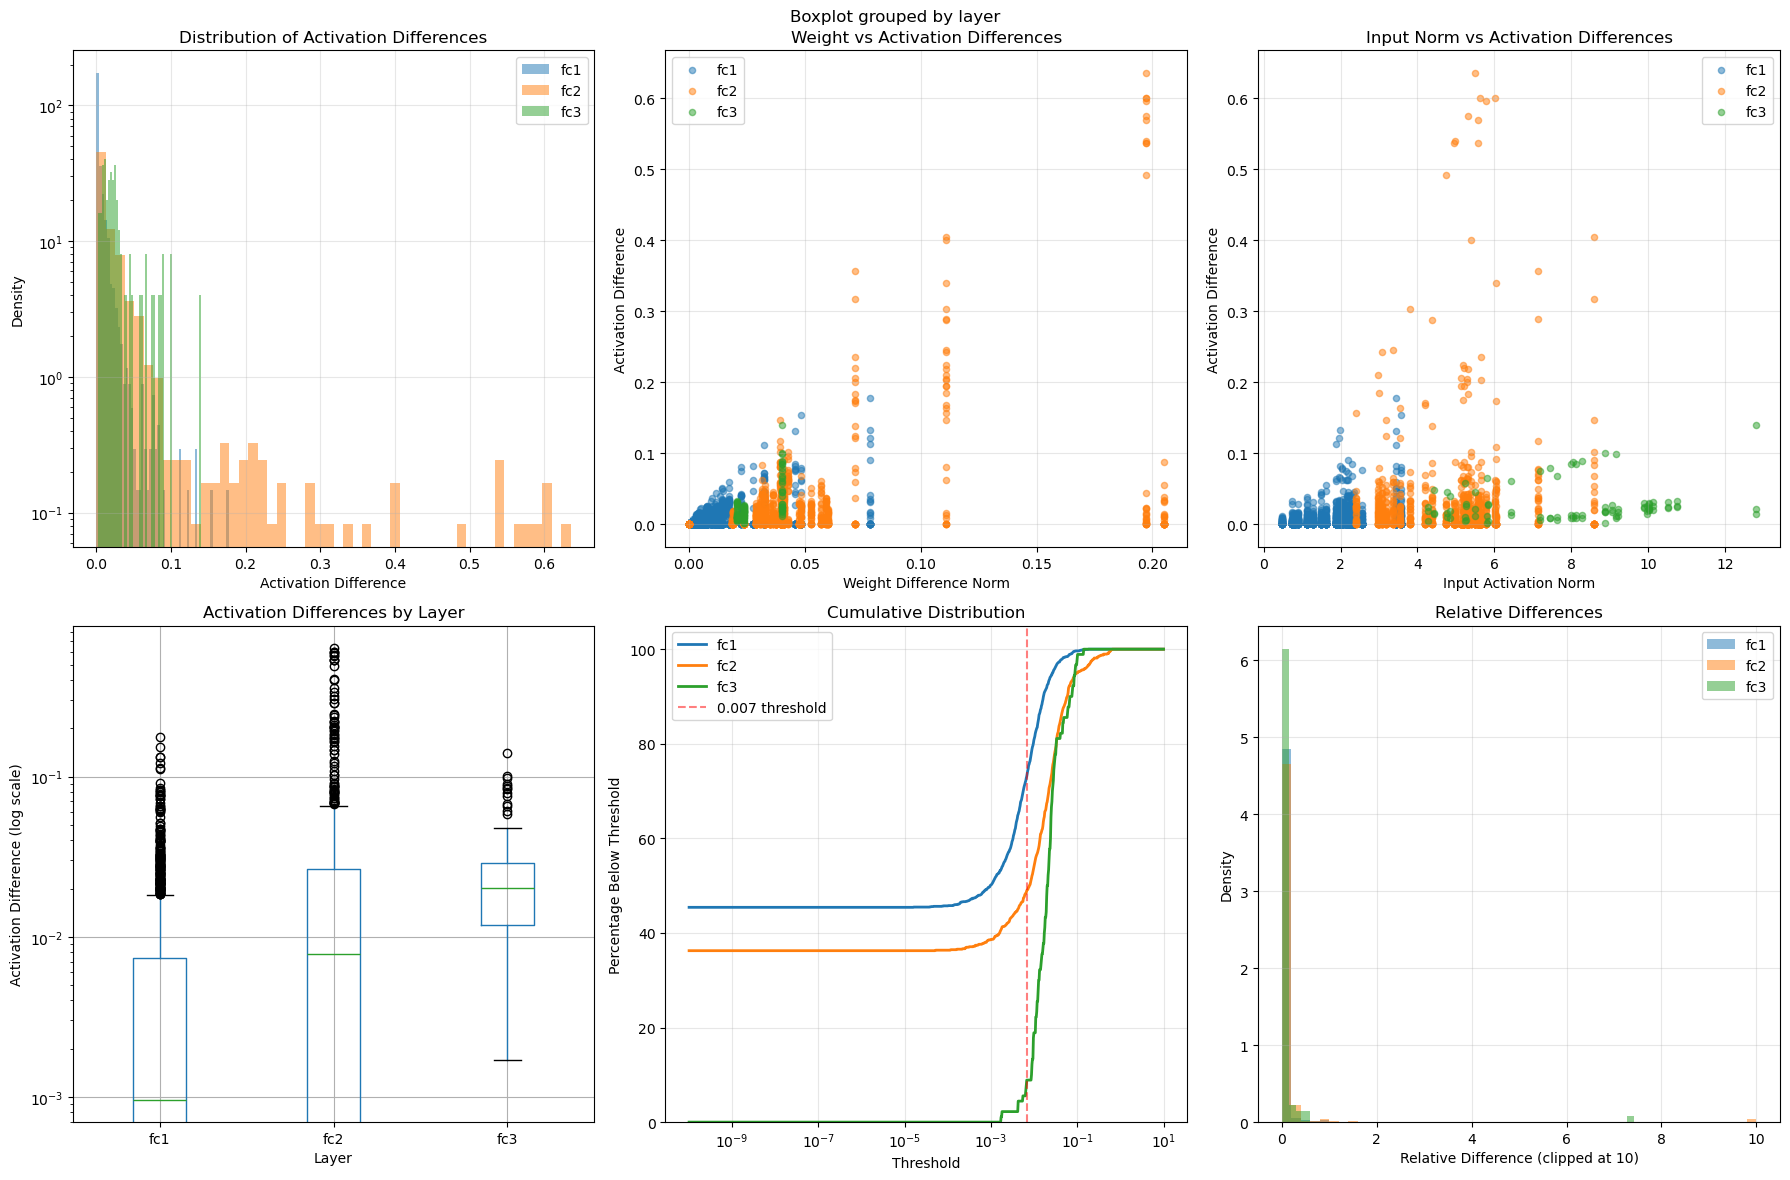


Corrected Analysis Summary:
            min      mean    median       max       std       p95       p99  \
layer                                                                         
fc1    0.000000  0.006289  0.000962  0.177726  0.013556  0.026530  0.071539   
fc2    0.000000  0.027988  0.007827  0.635580  0.071771  0.096846  0.440304   
fc3    0.001691  0.028193  0.020268  0.140079  0.026119  0.086506  0.105429   

          p99.9  
layer            
fc1    0.135163  
fc2    0.602194  
fc3    0.136614  

True Minimum Threshold Analysis:
Global minimum activation difference: 0.00e+00
Global maximum activation difference: 6.36e-01

Recommended thresholds based on percentiles:
  90%: 3.11e-02
  95%: 5.48e-02
  99%: 1.94e-01
  99.9%: 5.97e-01
  99.99%: 6.25e-01

Gradient reconstruction threshold (0.007) captures:
  fc1: 74.0% of activations
  fc2: 49.1% of activations
  fc3: 8.9% of activations


In [22]:
# %%
def analyze_activation_differences(model1, model2, X_data):
    """
    Analyze differences between activations using the formula:
    f(A_{i-1} @ W_i + b_i) - f(A_{i-1} @ W'_i + b'_i)
    where A_{i-1} is from model1 (verified model) and W', b' are from model2
    """
    results = []
    
    # Get activations from model1 (verified model)
    activations1 = {}
    hooks = []
    
    def get_activation(name):
        def hook(module, input, output):
            activations1[name] = {
                'input': input[0].detach(),
                'output': output.detach()
            }
        return hook
    
    # Register hooks for model1
    hooks.append(model1.fc1.register_forward_hook(get_activation('fc1')))
    hooks.append(model1.fc2.register_forward_hook(get_activation('fc2')))
    hooks.append(model1.fc3.register_forward_hook(get_activation('fc3')))
    
    # Forward pass for model1
    model1.eval()
    with torch.no_grad():
        _ = model1(X_data)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Get weights and biases from both models
    weights1 = {
        'fc1': {'W': model1.fc1.weight, 'b': model1.fc1.bias},
        'fc2': {'W': model2.fc2.weight, 'b': model1.fc2.bias},
        'fc3': {'W': model1.fc3.weight, 'b': model1.fc3.bias}
    }
    
    weights2 = {
        'fc1': {'W': model2.fc1.weight, 'b': model2.fc1.bias},
        'fc2': {'W': model2.fc2.weight, 'b': model2.fc2.bias},
        'fc3': {'W': model2.fc3.weight, 'b': model2.fc3.bias}
    }
    
    layers = ['fc1', 'fc2', 'fc3']
    
    for layer_idx, layer in enumerate(layers):
        # Get input activations (A_{i-1})
        if layer_idx == 0:
            # For first layer, input is the data itself
            A_prev = X_data
        else:
            # For other layers, use output from previous layer (after ReLU)
            prev_layer = layers[layer_idx - 1]
            A_prev = torch.relu(activations1[prev_layer]['output'])
        
        # Get weights and biases
        W1 = weights1[layer]['W']
        b1 = weights1[layer]['b']
        W2 = weights2[layer]['W']
        b2 = weights2[layer]['b']
        
        # Calculate activations using both models' weights
        # z1 = A_{i-1} @ W1^T + b1 (using model1 weights)
        # z2 = A_{i-1} @ W2^T + b2 (using model2 weights)
        z1 = torch.matmul(A_prev, W1.t()) + b1
        z2 = torch.matmul(A_prev, W2.t()) + b2
        
        # Apply activation function (ReLU for hidden layers, none for output)
        if layer_idx < len(layers) - 1:  # Hidden layers
            act1 = torch.relu(z1)
            act2 = torch.relu(z2)
        else:  # Output layer
            act1 = z1
            act2 = z2
        
        # Calculate differences
        abs_diff = torch.abs(act1 - act2)
        
        # Store results for each sample and neuron
        for sample_idx in range(act1.shape[0]):
            for neuron_idx in range(act1.shape[1]):
                neuron_diff = abs_diff[sample_idx, neuron_idx].item()
                
                results.append({
                    'layer': layer,
                    'sample_idx': sample_idx,
                    'neuron_idx': neuron_idx,
                    'activation_model1_weights': act1[sample_idx, neuron_idx].item(),
                    'activation_model2_weights': act2[sample_idx, neuron_idx].item(),
                    'abs_difference': neuron_diff,
                    'relative_difference': neuron_diff / (abs(act1[sample_idx, neuron_idx].item()) + 1e-10),
                    'input_activation_norm': torch.norm(A_prev[sample_idx]).item()
                })
    
    return pd.DataFrame(results)

# %%
# Alternative implementation with more detailed analysis
def analyze_activation_differences_detailed(model1, model2, X_data):
    """
    Detailed analysis with intermediate computations
    """
    results = []
    
    # Get all intermediate activations from model1
    model1.eval()
    model2.eval()
    
    with torch.no_grad():
        # Layer 1
        A0 = X_data  # Input
        
        # FC1 computations
        z1_m1 = torch.matmul(A0, model1.fc1.weight.t()) + model1.fc1.bias
        z1_m2 = torch.matmul(A0, model2.fc1.weight.t()) + model2.fc1.bias
        A1_m1 = torch.relu(z1_m1)
        A1_m2 = torch.relu(z1_m2)
        
        # FC2 computations (using A1 from model1)
        z2_m1 = torch.matmul(A1_m1, model1.fc2.weight.t()) + model1.fc2.bias
        z2_m2 = torch.matmul(A1_m1, model2.fc2.weight.t()) + model2.fc2.bias
        A2_m1 = torch.relu(z2_m1)
        A2_m2 = torch.relu(z2_m2)
        
        # FC3 computations (using A2 from model1)
        z3_m1 = torch.matmul(A2_m1, model1.fc3.weight.t()) + model1.fc3.bias
        z3_m2 = torch.matmul(A2_m1, model2.fc3.weight.t()) + model2.fc3.bias
        A3_m1 = z3_m1  # No activation on output layer
        A3_m2 = z3_m2
        
    # Store all activations
    activations = {
        'fc1': {'model1': A1_m1, 'model2': A1_m2, 'input': A0},
        'fc2': {'model1': A2_m1, 'model2': A2_m2, 'input': A1_m1},
        'fc3': {'model1': A3_m1, 'model2': A3_m2, 'input': A2_m1}
    }
    
    # Analyze differences
    for layer in ['fc1', 'fc2', 'fc3']:
        act_m1 = activations[layer]['model1']
        act_m2 = activations[layer]['model2']
        input_act = activations[layer]['input']
        
        abs_diff = torch.abs(act_m1 - act_m2)
        
        for sample_idx in range(act_m1.shape[0]):
            for neuron_idx in range(act_m1.shape[1]):
                diff = abs_diff[sample_idx, neuron_idx].item()
                
                # Get weight differences
                if layer == 'fc1':
                    w_diff = torch.norm(model1.fc1.weight[neuron_idx] - model2.fc1.weight[neuron_idx]).item()
                    b_diff = abs(model1.fc1.bias[neuron_idx] - model2.fc1.bias[neuron_idx]).item()
                elif layer == 'fc2':
                    w_diff = torch.norm(model1.fc2.weight[neuron_idx] - model2.fc2.weight[neuron_idx]).item()
                    b_diff = abs(model1.fc2.bias[neuron_idx] - model2.fc2.bias[neuron_idx]).item()
                else:  # fc3
                    w_diff = torch.norm(model1.fc3.weight[neuron_idx] - model2.fc3.weight[neuron_idx]).item()
                    b_diff = abs(model1.fc3.bias[neuron_idx] - model2.fc3.bias[neuron_idx]).item()
                
                results.append({
                    'layer': layer,
                    'sample_idx': sample_idx,
                    'neuron_idx': neuron_idx,
                    'activation_diff': diff,
                    'activation_m1': act_m1[sample_idx, neuron_idx].item(),
                    'activation_m2': act_m2[sample_idx, neuron_idx].item(),
                    'weight_diff_norm': w_diff,
                    'bias_diff': b_diff,
                    'input_norm': torch.norm(input_act[sample_idx]).item(),
                    'relative_diff': diff / (abs(act_m1[sample_idx, neuron_idx].item()) + 1e-10)
                })
    
    return pd.DataFrame(results)

# %%
# Re-analyze with the correct method
print("\nAnalyzing with correct formula...")
diff_df_correct = analyze_activation_differences_detailed(model1, model2, X_test_t)

# %%
# Visualize the corrected results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Activation Differences: f(A_{i-1}W_i + b_i) - f(A_{i-1}W\'_i + b\'_i)', fontsize=16)

# 1. Distribution of activation differences by layer
ax = axes[0, 0]
for layer in ['fc1', 'fc2', 'fc3']:
    layer_data = diff_df_correct[diff_df_correct['layer'] == layer]['activation_diff']
    ax.hist(layer_data, bins=50, alpha=0.5, label=layer, density=True)

ax.set_xlabel('Activation Difference')
ax.set_ylabel('Density')
ax.set_title('Distribution of Activation Differences')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Weight differences vs activation differences
ax = axes[0, 1]
for layer in ['fc1', 'fc2', 'fc3']:
    layer_data = diff_df_correct[diff_df_correct['layer'] == layer]
    ax.scatter(layer_data['weight_diff_norm'], layer_data['activation_diff'], 
               alpha=0.5, label=layer, s=20)

ax.set_xlabel('Weight Difference Norm')
ax.set_ylabel('Activation Difference')
ax.set_title('Weight vs Activation Differences')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Input norm vs activation differences
ax = axes[0, 2]
for layer in ['fc1', 'fc2', 'fc3']:
    layer_data = diff_df_correct[diff_df_correct['layer'] == layer]
    ax.scatter(layer_data['input_norm'], layer_data['activation_diff'], 
               alpha=0.5, label=layer, s=20)

ax.set_xlabel('Input Activation Norm')
ax.set_ylabel('Activation Difference')
ax.set_title('Input Norm vs Activation Differences')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Box plot by layer
ax = axes[1, 0]
diff_df_correct.boxplot(column='activation_diff', by='layer', ax=ax)
ax.set_yscale('log')
ax.set_title('Activation Differences by Layer')
ax.set_xlabel('Layer')
ax.set_ylabel('Activation Difference (log scale)')

# 5. Cumulative distribution
ax = axes[1, 1]
thresholds = np.logspace(-10, 1, 1000)

for layer in ['fc1', 'fc2', 'fc3']:
    layer_data = diff_df_correct[diff_df_correct['layer'] == layer]['activation_diff'].values
    percentages = []
    
    for thresh in thresholds:
        pct = np.sum(layer_data <= thresh) / len(layer_data) * 100
        percentages.append(pct)
    
    ax.semilogx(thresholds, percentages, label=layer, linewidth=2)

# Add reference lines
ax.axvline(x=0.007, color='red', linestyle='--', alpha=0.5, label='0.007 threshold')
ax.set_xlabel('Threshold')
ax.set_ylabel('Percentage Below Threshold')
ax.set_title('Cumulative Distribution')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)

# 6. Relative differences
ax = axes[1, 2]
for layer in ['fc1', 'fc2', 'fc3']:
    layer_data = diff_df_correct[diff_df_correct['layer'] == layer]['relative_diff']
    layer_data_clipped = np.clip(layer_data, 0, 10)  # Clip for visualization
    ax.hist(layer_data_clipped, bins=50, alpha=0.5, label=layer, density=True)

ax.set_xlabel('Relative Difference (clipped at 10)')
ax.set_ylabel('Density')
ax.set_title('Relative Differences')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('corrected_activation_differences.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Summary statistics with the corrected method
print("\nCorrected Analysis Summary:")
print("="*70)

summary_stats = diff_df_correct.groupby('layer')['activation_diff'].agg([
    'min', 'mean', 'median', 'max', 'std',
    lambda x: np.percentile(x, 95),
    lambda x: np.percentile(x, 99),
    lambda x: np.percentile(x, 99.9)
])
summary_stats.columns = ['min', 'mean', 'median', 'max', 'std', 'p95', 'p99', 'p99.9']

print(summary_stats)

# %%
# Find the true minimum threshold
print("\nTrue Minimum Threshold Analysis:")
print("="*50)

global_min = diff_df_correct['activation_diff'].min()
global_max = diff_df_correct['activation_diff'].max()

print(f"Global minimum activation difference: {global_min:.2e}")
print(f"Global maximum activation difference: {global_max:.2e}")

# Threshold recommendations
print("\nRecommended thresholds based on percentiles:")
for p in [90, 95, 99, 99.9, 99.99]:
    threshold = np.percentile(diff_df_correct['activation_diff'], p)
    print(f"  {p}%: {threshold:.2e}")

# Compare with gradient reconstruction threshold
print(f"\nGradient reconstruction threshold (0.007) captures:")
for layer in ['fc1', 'fc2', 'fc3']:
    layer_data = diff_df_correct[diff_df_correct['layer'] == layer]['activation_diff']
    pct_below = (layer_data <= 0.007).sum() / len(layer_data) * 100
    print(f"  {layer}: {pct_below:.1f}% of activations")


In [16]:
# Analyze differences
diff_df = analyze_activation_differences(activations1, activations2)
print(f"Total activation comparisons: {len(diff_df)}")

Total activation comparisons: 2970


In [17]:
# Find minimum differences per layer
print("\nMinimum absolute differences per layer:")
print("="*50)

min_diffs_by_layer = diff_df.groupby('layer')['abs_difference'].agg(['min', 'mean', 'max', 'std'])
print(min_diffs_by_layer)


Minimum absolute differences per layer:
            min      mean       max       std
layer                                        
fc1    0.000000  0.013410  0.177726  0.021442
fc2    0.000028  0.048032  0.880938  0.091601
fc3    0.001657  0.056663  0.207963  0.045293


In [18]:
# Find the neuron with the smallest difference for each layer
print("\nNeurons with smallest differences:")
print("="*50)

for layer in ['fc1', 'fc2', 'fc3']:
    layer_data = diff_df[diff_df['layer'] == layer]
    min_idx = layer_data['abs_difference'].idxmin()
    min_row = layer_data.loc[min_idx]
    
    print(f"\n{layer}:")
    print(f"  Sample {min_row['sample_idx']}, Neuron {min_row['neuron_idx']}")
    print(f"  Model1 activation: {min_row['activation_model1']:.6f}")
    print(f"  Model2 activation: {min_row['activation_model2']:.6f}")
    print(f"  Absolute difference: {min_row['abs_difference']:.2e}")
    print(f"  Relative difference: {min_row['relative_difference']:.2%}")


Neurons with smallest differences:

fc1:
  Sample 0, Neuron 1
  Model1 activation: -0.575215
  Model2 activation: -0.575215
  Absolute difference: 0.00e+00
  Relative difference: 0.00%

fc2:
  Sample 12, Neuron 28
  Model1 activation: 0.031822
  Model2 activation: 0.031795
  Absolute difference: 2.76e-05
  Relative difference: 0.09%

fc3:
  Sample 9, Neuron 1
  Model1 activation: 2.851790
  Model2 activation: 2.850134
  Absolute difference: 1.66e-03
  Relative difference: 0.06%


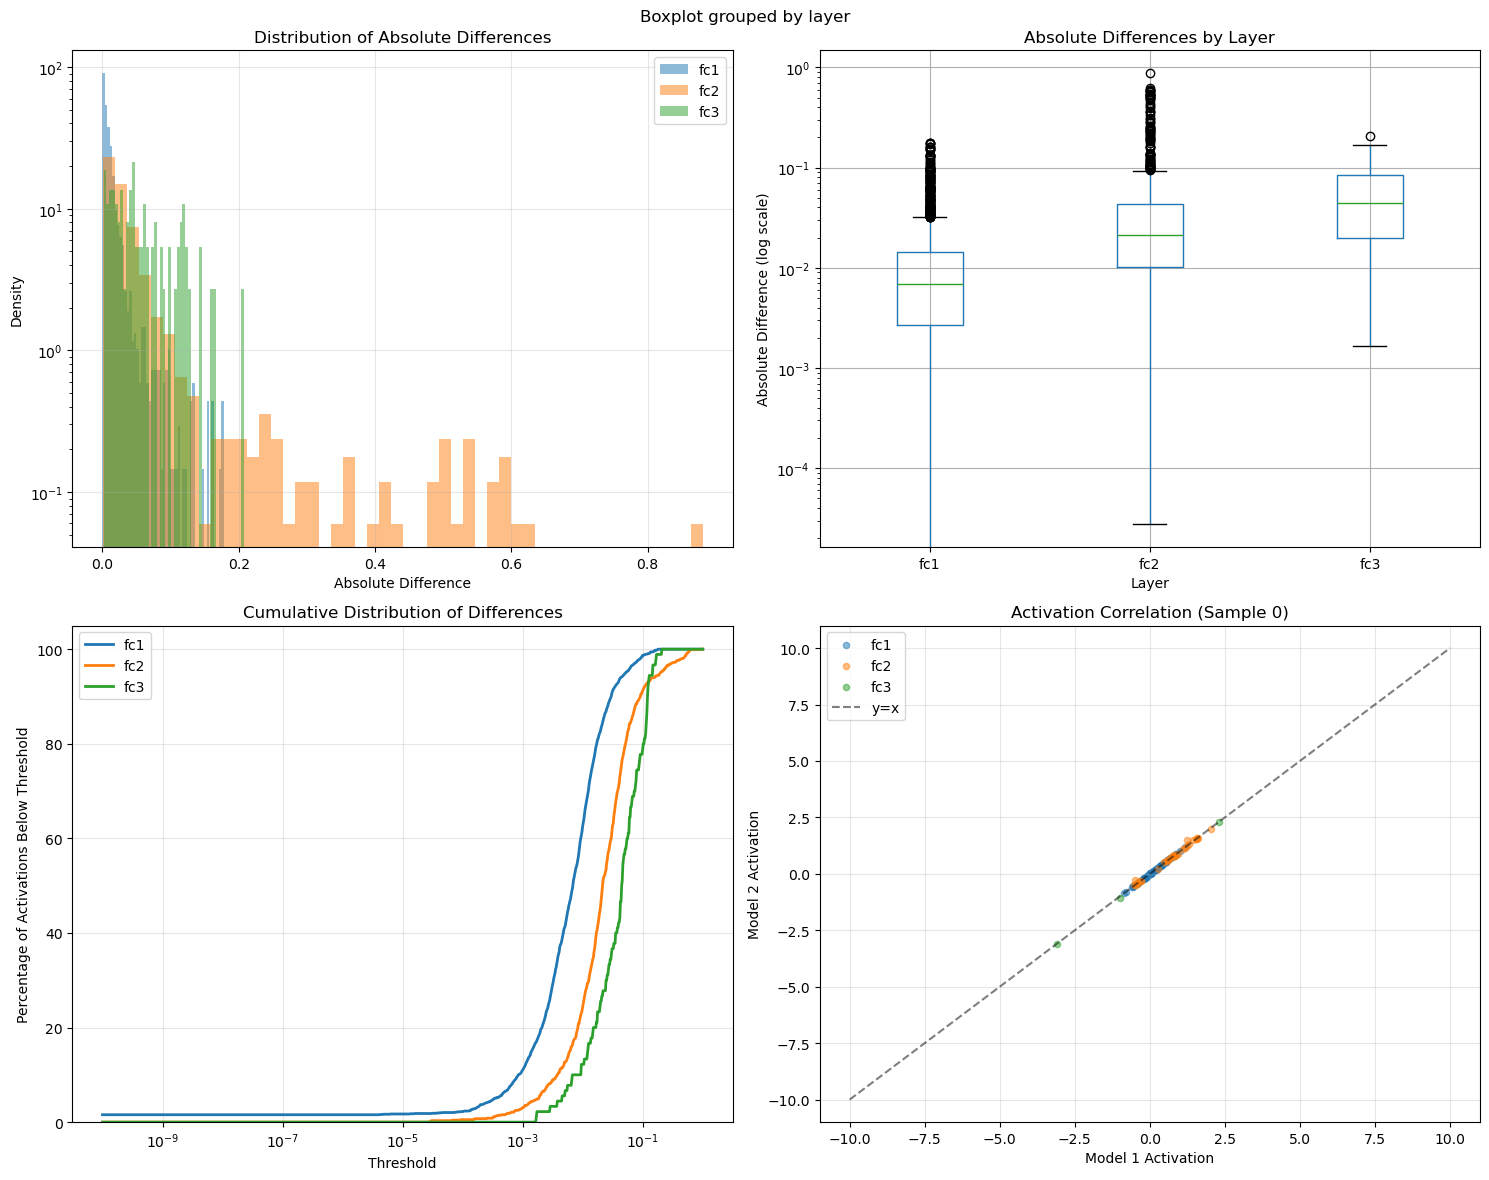

In [19]:
# Visualize distribution of differences
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution of Activation Differences Between Identically Initialized Models', fontsize=16)

# 1. Histogram of absolute differences by layer
ax = axes[0, 0]
for layer in ['fc1', 'fc2', 'fc3']:
    layer_data = diff_df[diff_df['layer'] == layer]['abs_difference']
    ax.hist(layer_data, bins=50, alpha=0.5, label=layer, density=True)

ax.set_xlabel('Absolute Difference')
ax.set_ylabel('Density')
ax.set_title('Distribution of Absolute Differences')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Box plot of differences by layer
ax = axes[0, 1]
diff_df.boxplot(column='abs_difference', by='layer', ax=ax)
ax.set_yscale('log')
ax.set_title('Absolute Differences by Layer')
ax.set_xlabel('Layer')
ax.set_ylabel('Absolute Difference (log scale)')

# 3. Cumulative distribution
ax = axes[1, 0]
thresholds = np.logspace(-10, 0, 1000)

for layer in ['fc1', 'fc2', 'fc3']:
    layer_data = diff_df[diff_df['layer'] == layer]['abs_difference'].values
    percentages = []
    
    for thresh in thresholds:
        pct = np.sum(layer_data <= thresh) / len(layer_data) * 100
        percentages.append(pct)
    
    ax.semilogx(thresholds, percentages, label=layer, linewidth=2)

ax.set_xlabel('Threshold')
ax.set_ylabel('Percentage of Activations Below Threshold')
ax.set_title('Cumulative Distribution of Differences')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)

# 4. Scatter plot: Model1 vs Model2 activations
ax = axes[1, 1]
sample_data = diff_df[diff_df['sample_idx'] == 0]  # First sample

for layer in ['fc1', 'fc2', 'fc3']:
    layer_data = sample_data[sample_data['layer'] == layer]
    ax.scatter(layer_data['activation_model1'], 
              layer_data['activation_model2'], 
              alpha=0.5, label=layer, s=20)

ax.plot([-10, 10], [-10, 10], 'k--', alpha=0.5, label='y=x')
ax.set_xlabel('Model 1 Activation')
ax.set_ylabel('Model 2 Activation')
ax.set_title('Activation Correlation (Sample 0)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('identical_init_differences.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
print("\nThreshold Analysis for Identically Initialized Models:")
print("="*70)

test_thresholds = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

threshold_analysis = []

for thresh in test_thresholds:
    row = {'threshold': thresh}
    
    for layer in ['fc1', 'fc2', 'fc3']:
        layer_data = diff_df[diff_df['layer'] == layer]['abs_difference'].values
        pass_rate = np.sum(layer_data <= thresh) / len(layer_data) * 100
        row[f'{layer}_pass_rate'] = pass_rate
    
    # All layers simultaneously
    all_pass = 0
    total_samples = len(diff_df['sample_idx'].unique())
    
    for sample_idx in diff_df['sample_idx'].unique():
        sample_data = diff_df[diff_df['sample_idx'] == sample_idx]
        
        # Check if ALL neurons in ALL layers pass for this sample
        max_diff_per_layer = sample_data.groupby('layer')['abs_difference'].max()
        if all(max_diff_per_layer <= thresh):
            all_pass += 1
    
    row['all_layers_pass_rate'] = (all_pass / total_samples) * 100
    threshold_analysis.append(row)

threshold_df = pd.DataFrame(threshold_analysis)
print(threshold_df.to_string(index=False))


Threshold Analysis for Identically Initialized Models:
   threshold  fc1_pass_rate  fc2_pass_rate  fc3_pass_rate  all_layers_pass_rate
1.000000e-08       1.562500       0.000000       0.000000                   0.0
1.000000e-07       1.562500       0.000000       0.000000                   0.0
1.000000e-06       1.562500       0.000000       0.000000                   0.0
1.000000e-05       1.718750       0.000000       0.000000                   0.0
1.000000e-04       2.239583       0.520833       0.000000                   0.0
1.000000e-03      11.041667       3.020833       0.000000                   0.0
1.000000e-02      62.708333      24.270833      12.222222                   0.0
1.000000e-01      98.697917      91.250000      78.888889                   0.0



Practical Threshold Determination:
Global minimum difference: 0.00e+00
Global maximum difference: 8.81e-01

Thresholds for different confidence levels:
  90% of differences are below: 5.54e-02
  95% of differences are below: 9.28e-02
  99% of differences are below: 2.85e-01
  99.9% of differences are below: 5.98e-01

Neurons with most consistent activations (lowest max difference):

fc1 - Top 5 most consistent neurons:
                 min      mean       max       std
neuron_idx                                        
1           0.000000  0.000000  0.000000  0.000000
25          0.000031  0.001264  0.002777  0.000693
47          0.000175  0.001341  0.002964  0.000790
33          0.000231  0.001296  0.003039  0.000779
12          0.001635  0.002881  0.003815  0.000494

fc2 - Top 5 most consistent neurons:
                 min      mean       max       std
neuron_idx                                        
4           0.000153  0.005826  0.014171  0.004107
26          0.000092  0.0047

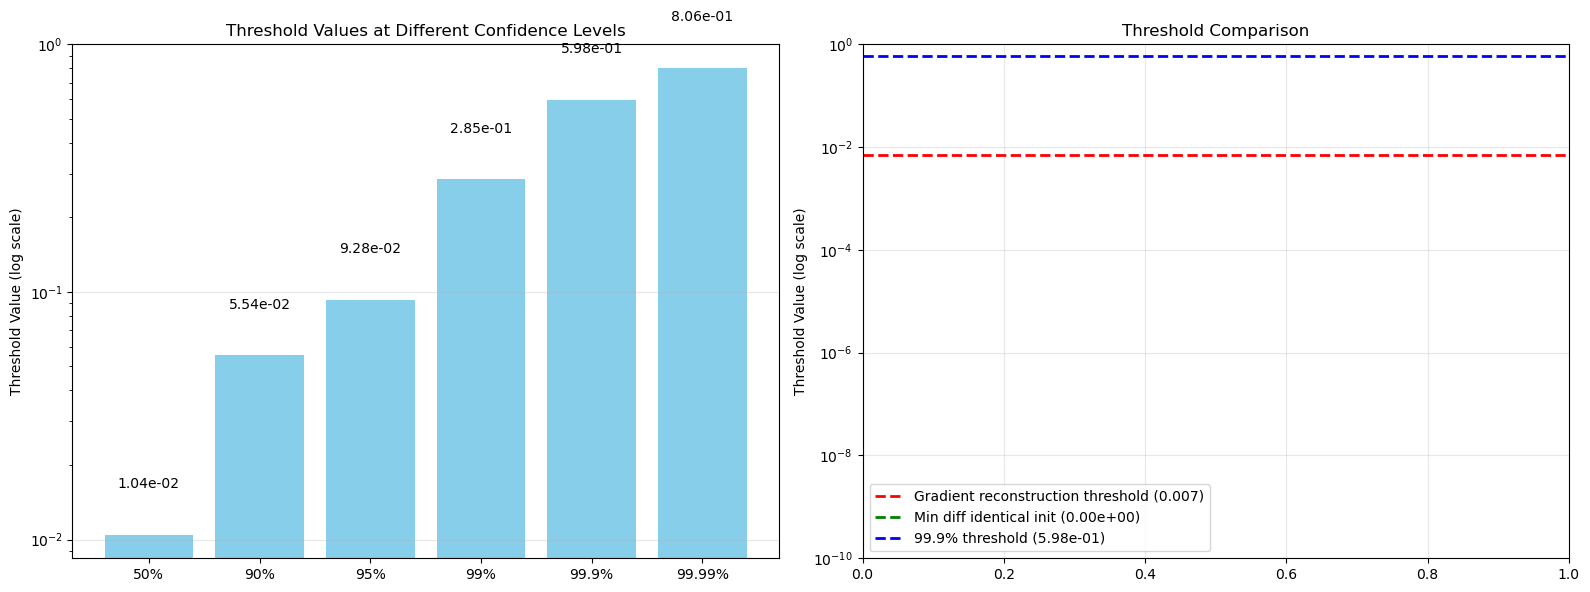


THRESHOLD RECOMMENDATION SUMMARY

Based on identical initialization analysis:
  - Minimum observed difference: 0.00e+00
  - 99.9th percentile difference: 5.98e-01
  - 99.99th percentile difference: 8.06e-01

Comparison with gradient reconstruction:
  - Gradient reconstruction threshold: 0.007
  - Ratio: 0x larger than 99.9th percentile

RECOMMENDATION:
  Use threshold of 8.06e-01 for distinguishing genuinely different activations
  This ensures 99.99% confidence that differences above this threshold are meaningful


In [21]:
# Find practical threshold
print("\nPractical Threshold Determination:")
print("="*50)

# Find minimum difference across all comparisons
global_min_diff = diff_df['abs_difference'].min()
global_max_diff = diff_df['abs_difference'].max()

print(f"Global minimum difference: {global_min_diff:.2e}")
print(f"Global maximum difference: {global_max_diff:.2e}")

# Find threshold for different confidence levels
confidence_levels = [90, 95, 99, 99.9]

print("\nThresholds for different confidence levels:")
for conf in confidence_levels:
    threshold = np.percentile(diff_df['abs_difference'], conf)
    print(f"  {conf}% of differences are below: {threshold:.2e}")

# %%
# Analyze per-neuron statistics
neuron_stats = diff_df.groupby(['layer', 'neuron_idx'])['abs_difference'].agg(['min', 'mean', 'max', 'std'])

print("\nNeurons with most consistent activations (lowest max difference):")
print("="*60)

for layer in ['fc1', 'fc2', 'fc3']:
    layer_stats = neuron_stats.loc[layer].sort_values('max')
    print(f"\n{layer} - Top 5 most consistent neurons:")
    print(layer_stats.head())

# %%
# Create final recommendation plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Show practical threshold ranges
all_diffs = diff_df['abs_difference'].values
percentiles = [50, 90, 95, 99, 99.9, 99.99]
threshold_values = [np.percentile(all_diffs, p) for p in percentiles]

bars = ax1.bar(range(len(percentiles)), threshold_values, color='skyblue')
ax1.set_xticks(range(len(percentiles)))
ax1.set_xticklabels([f'{p}%' for p in percentiles])
ax1.set_yscale('log')
ax1.set_ylabel('Threshold Value (log scale)')
ax1.set_title('Threshold Values at Different Confidence Levels')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, threshold_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height*1.5,
             f'{val:.2e}', ha='center', va='bottom', fontsize=10)

# Right: Compare with gradient-based reconstruction threshold
ax2.axhline(y=0.007, color='red', linestyle='--', linewidth=2, label='Gradient reconstruction threshold (0.007)')
ax2.axhline(y=global_min_diff, color='green', linestyle='--', linewidth=2, label=f'Min diff identical init ({global_min_diff:.2e})')
ax2.axhline(y=np.percentile(all_diffs, 99.9), color='blue', linestyle='--', linewidth=2, 
            label=f'99.9% threshold ({np.percentile(all_diffs, 99.9):.2e})')

ax2.set_ylim(1e-10, 1e0)
ax2.set_yscale('log')
ax2.set_ylabel('Threshold Value (log scale)')
ax2.set_title('Threshold Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_recommendation.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Final summary
print("\n" + "="*80)
print("THRESHOLD RECOMMENDATION SUMMARY")
print("="*80)

print("\nBased on identical initialization analysis:")
print(f"  - Minimum observed difference: {global_min_diff:.2e}")
print(f"  - 99.9th percentile difference: {np.percentile(all_diffs, 99.9):.2e}")
print(f"  - 99.99th percentile difference: {np.percentile(all_diffs, 99.99):.2e}")

print("\nComparison with gradient reconstruction:")
print(f"  - Gradient reconstruction threshold: 0.007")
print(f"  - Ratio: {0.007 / np.percentile(all_diffs, 99.9):.0f}x larger than 99.9th percentile")

print("\nRECOMMENDATION:")
practical_threshold = np.percentile(all_diffs, 99.99)
print(f"  Use threshold of {practical_threshold:.2e} for distinguishing genuinely different activations")
print(f"  This ensures 99.99% confidence that differences above this threshold are meaningful")

Training multiple model pairs for threshold analysis...

Training model pair 1/5

Training model pair 2/5

Training model pair 3/5

Training model pair 4/5

Training model pair 5/5
Same model differences: 14850 values
Different model differences: 14850 values

ROC AUC: 0.7934
Optimal threshold: 4.89e-06
TPR at optimal: 0.5868
FPR at optimal: 0.0000


C:\Users\hskay\AppData\Local\Temp\ipykernel_31204\181906226.py:203: RuntimeWarning: divide by zero encountered in log10
  bins = np.logspace(np.log10(min(same_model_diffs.min(), different_model_diffs.min())),
c:\Users\hskay\anaconda3\Lib\site-packages\numpy\core\function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
c:\Users\hskay\anaconda3\Lib\site-packages\numpy\core\function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start
C:\Users\hskay\AppData\Local\Temp\ipykernel_31204\181906226.py:254: RuntimeWarning: divide by zero encountered in log10
  test_thresholds = np.logspace(np.log10(all_diffs.min()), np.log10(all_diffs.max()), 100)
c:\Users\hskay\anaconda3\Lib\site-packages\numpy\core\function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
c:\Users\hskay\anaconda3\Lib\site-packages\numpy\core\function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start


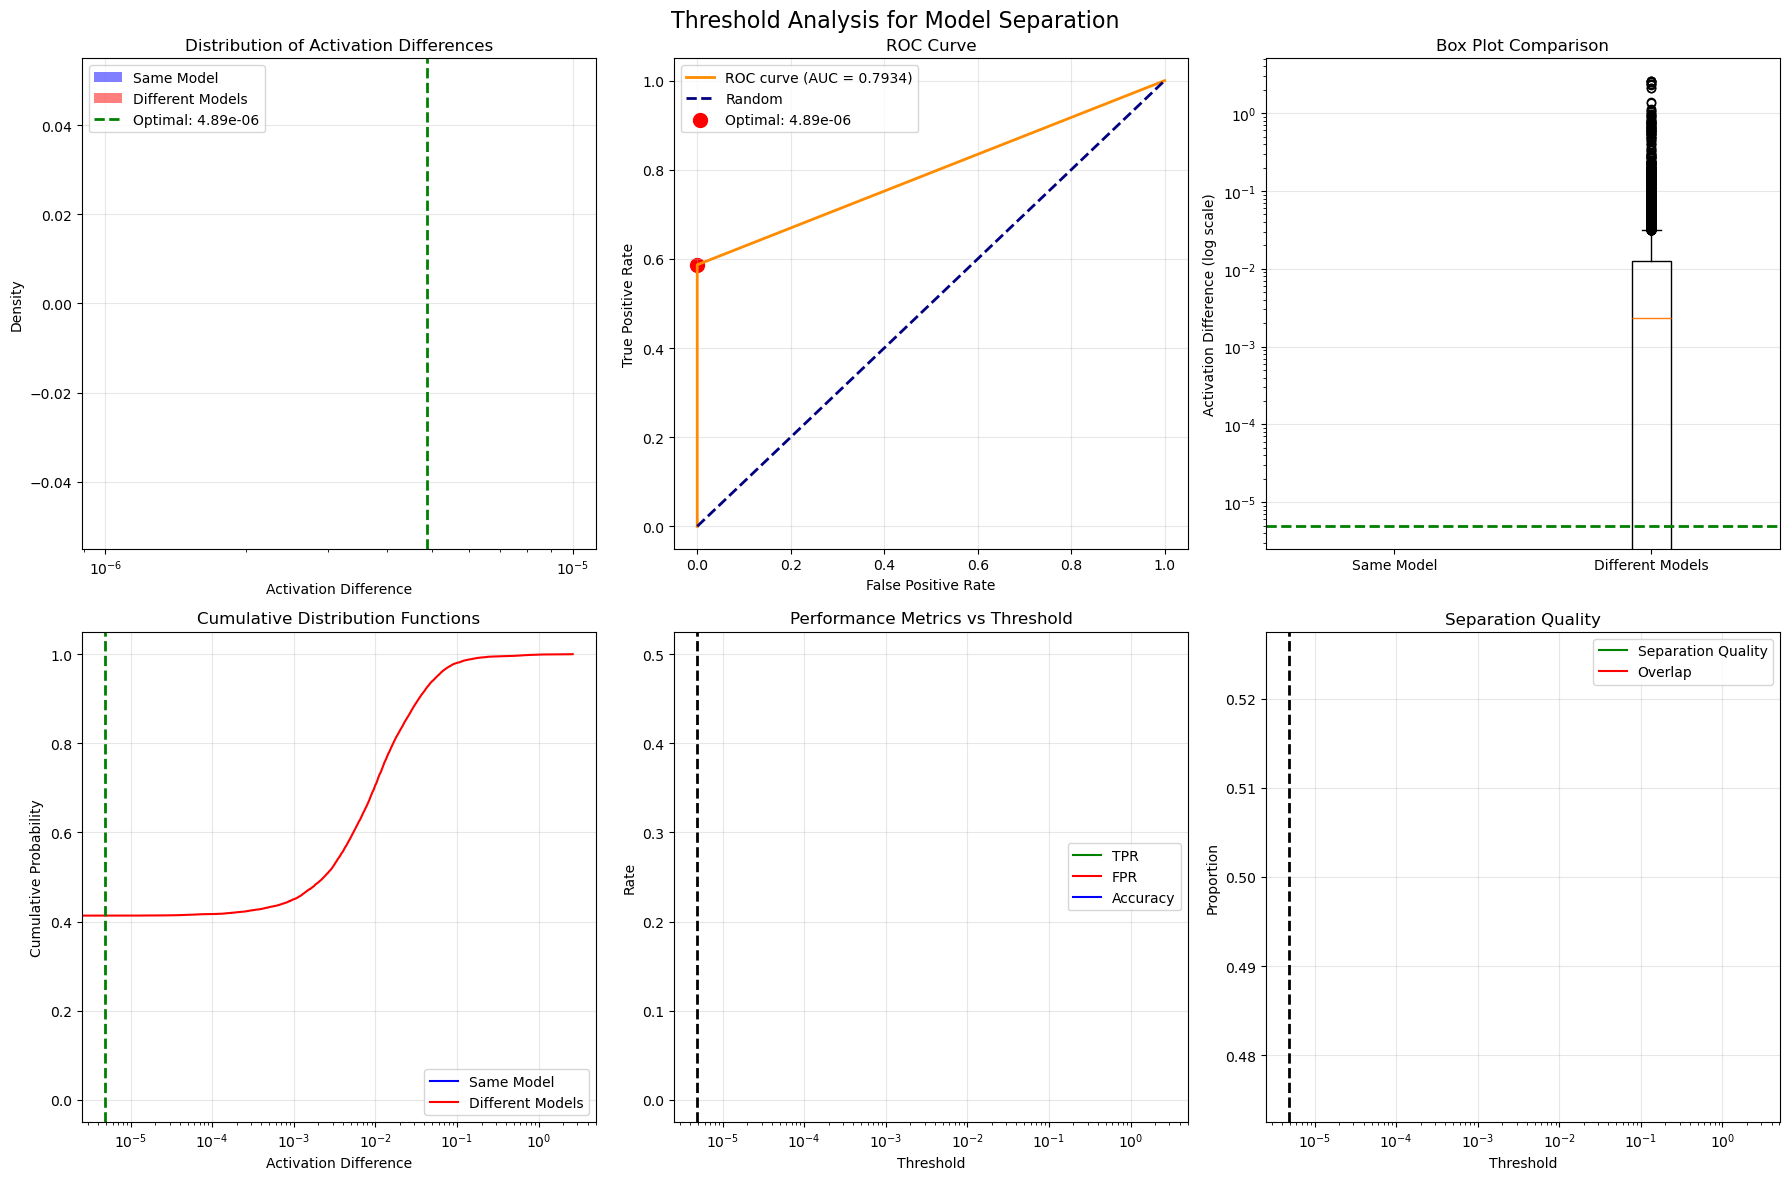


STATISTICAL SUMMARY

Same Model Statistics:
  Min: 0.00e+00
  Max: 0.00e+00
  Mean: 0.00e+00
  Median: 0.00e+00
  95th percentile: 0.00e+00
  99th percentile: 0.00e+00

Different Models Statistics:
  Min: 0.00e+00
  Max: 2.62e+00
  Mean: 1.61e-02
  Median: 2.34e-03
  5th percentile: 0.00e+00
  1st percentile: 0.00e+00

Overlap region: [0.00e+00, 0.00e+00]

Classification Performance at Key Thresholds:
------------------------------------------------------------
Threshold      | FPR    | FNR    | Accuracy | F1-Score
------------------------------------------------------------
0.00e+00 | 0.0000 | 0.4132 | 0.7934 | 0.7396
0.00e+00 | 0.0000 | 0.4132 | 0.7934 | 0.7396
0.00e+00 | 0.0000 | 0.4132 | 0.7934 | 0.7396
0.00e+00 | 0.0000 | 0.4132 | 0.7934 | 0.7396
4.89e-06 | 0.0000 | 0.4133 | 0.7934 | 0.7395
7.00e-03 | 0.0000 | 0.6416 | 0.6792 | 0.5277

THRESHOLD RECOMMENDATION FOR MODEL SEPARATION

Optimal threshold (maximizing TPR-FPR): 4.89e-06
This threshold achieves:
  - True Positive Rate: 5

C:\Users\hskay\AppData\Local\Temp\ipykernel_31204\181906226.py:405: RuntimeWarning: divide by zero encountered in log10
  bins = np.logspace(np.log10(all_diffs.min()), np.log10(all_diffs.max()), 100)


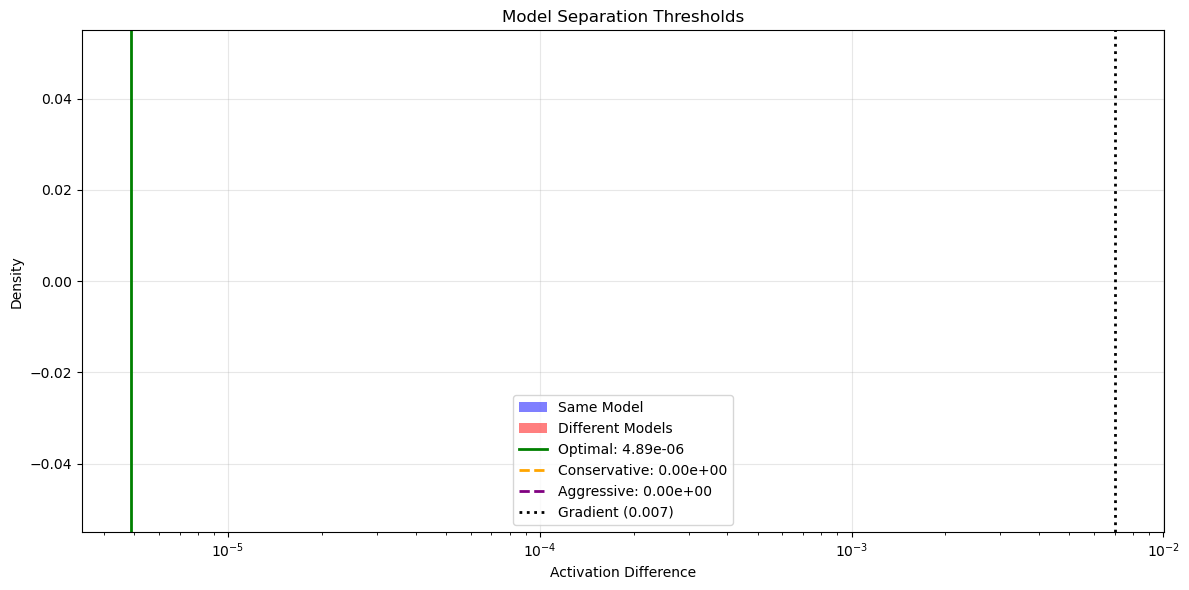

In [24]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

# %%
# Set random seeds
def set_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)
def compute_activation_differences(model_base, model_compare, X_data):
    """
    Compute activation differences using the formula:
    |f(A_{i-1} @ W_base + b_base) - f(A_{i-1} @ W_compare + b_compare)|
    where A_{i-1} comes from model_base
    """
    differences = []
    
    model_base.eval()
    model_compare.eval()
    
    with torch.no_grad():
        # Get intermediate activations from base model
        A0 = X_data
        
        # Layer 1
        z1_base = torch.matmul(A0, model_base.fc1.weight.t()) + model_base.fc1.bias
        A1_base = torch.relu(z1_base)
        
        # Compute layer 1 with compare model weights
        z1_compare = torch.matmul(A0, model_compare.fc1.weight.t()) + model_compare.fc1.bias
        A1_compare = torch.relu(z1_compare)
        
        # Layer 1 differences
        diff1 = torch.abs(A1_base - A1_compare).flatten().cpu().numpy()
        differences.extend(diff1)
        
        # Layer 2 (using A1 from base model)
        z2_base = torch.matmul(A1_base, model_base.fc2.weight.t()) + model_base.fc2.bias
        A2_base = torch.relu(z2_base)
        
        z2_compare = torch.matmul(A1_base, model_compare.fc2.weight.t()) + model_compare.fc2.bias
        A2_compare = torch.relu(z2_compare)
        
        # Layer 2 differences
        diff2 = torch.abs(A2_base - A2_compare).flatten().cpu().numpy()
        differences.extend(diff2)
        
        # Layer 3 (using A2 from base model)
        z3_base = torch.matmul(A2_base, model_base.fc3.weight.t()) + model_base.fc3.bias
        z3_compare = torch.matmul(A2_base, model_compare.fc3.weight.t()) + model_compare.fc3.bias
        
        # Layer 3 differences
        diff3 = torch.abs(z3_base - z3_compare).flatten().cpu().numpy()
        differences.extend(diff3)
    
    return differences
# %%
# Load and prepare data
data = load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_t = torch.FloatTensor(X_train_scaled)
X_test_t = torch.FloatTensor(X_test_scaled)
y_train_t = torch.LongTensor(y_train)
y_test_t = torch.LongTensor(y_test)

# %%
class IdenticalANN(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[64, 32], num_classes=3):
        super(IdenticalANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# %%
def train_model_with_shuffled_data(model, X_train, y_train, epochs=50, batch_size=32, lr=0.001):
    shuffle_idx = torch.randperm(len(X_train))
    X_shuffled = X_train[shuffle_idx]
    y_shuffled = y_train[shuffle_idx]
    
    dataset = TensorDataset(X_shuffled, y_shuffled)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    return model

# %%
# Train multiple pairs of models for robust analysis
print("Training multiple model pairs for threshold analysis...")

num_model_pairs = 5
all_same_model_diffs = []
all_different_model_diffs = []

for pair_idx in range(num_model_pairs):
    print(f"\nTraining model pair {pair_idx + 1}/{num_model_pairs}")
    
    # Initialize two models with identical weights
    model1 = IdenticalANN()
    model2 = IdenticalANN()
    
    # Save and load initial weights to ensure identical initialization
    initial_weights = model1.state_dict()
    model2.load_state_dict(initial_weights)
    
    # Train both models
    model1 = train_model_with_shuffled_data(model1, X_train_t, y_train_t, epochs=50)
    model2 = train_model_with_shuffled_data(model2, X_train_t, y_train_t, epochs=50)
    
    # Collect activation differences for SAME model (model1 with itself)
    same_model_diffs = compute_activation_differences(model1, model1, X_test_t)
    all_same_model_diffs.extend(same_model_diffs)
    
    # Collect activation differences for DIFFERENT models (model1 with model2)
    different_model_diffs = compute_activation_differences(model1, model2, X_test_t)
    all_different_model_diffs.extend(different_model_diffs)

# %%


# %%
# Convert to numpy arrays
same_model_diffs = np.array(all_same_model_diffs)
different_model_diffs = np.array(all_different_model_diffs)

print(f"Same model differences: {len(same_model_diffs)} values")
print(f"Different model differences: {len(different_model_diffs)} values")

# %%
# Create labels for ROC analysis
# 0 = same model, 1 = different models
labels = np.concatenate([
    np.zeros(len(same_model_diffs)),
    np.ones(len(different_model_diffs))
])

# Combine all differences
all_diffs = np.concatenate([same_model_diffs, different_model_diffs])

# %%
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, all_diffs)
roc_auc = auc(fpr, tpr)

# Find optimal threshold (Youden's J statistic)
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

print(f"\nROC AUC: {roc_auc:.4f}")
print(f"Optimal threshold: {optimal_threshold:.2e}")
print(f"TPR at optimal: {tpr[optimal_idx]:.4f}")
print(f"FPR at optimal: {fpr[optimal_idx]:.4f}")

# %%
# Comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Threshold Analysis for Model Separation', fontsize=16)

# 1. Distribution comparison
ax = axes[0, 0]
bins = np.logspace(np.log10(min(same_model_diffs.min(), different_model_diffs.min())), 
                   np.log10(max(same_model_diffs.max(), different_model_diffs.max())), 50)

ax.hist(same_model_diffs, bins=bins, alpha=0.5, label='Same Model', density=True, color='blue')
ax.hist(different_model_diffs, bins=bins, alpha=0.5, label='Different Models', density=True, color='red')
ax.axvline(optimal_threshold, color='green', linestyle='--', linewidth=2, label=f'Optimal: {optimal_threshold:.2e}')
ax.set_xscale('log')
ax.set_xlabel('Activation Difference')
ax.set_ylabel('Density')
ax.set_title('Distribution of Activation Differences')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. ROC Curve
ax = axes[0, 1]
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, 
           label=f'Optimal: {optimal_threshold:.2e}')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Box plots
ax = axes[0, 2]
data_to_plot = [same_model_diffs, different_model_diffs]
box_plot = ax.boxplot(data_to_plot, labels=['Same Model', 'Different Models'])
ax.set_yscale('log')
ax.axhline(optimal_threshold, color='green', linestyle='--', linewidth=2)
ax.set_ylabel('Activation Difference (log scale)')
ax.set_title('Box Plot Comparison')
ax.grid(True, alpha=0.3, axis='y')

# 4. Cumulative distributions
ax = axes[1, 0]
sorted_same = np.sort(same_model_diffs)
sorted_diff = np.sort(different_model_diffs)
ax.plot(sorted_same, np.linspace(0, 1, len(sorted_same)), label='Same Model', color='blue')
ax.plot(sorted_diff, np.linspace(0, 1, len(sorted_diff)), label='Different Models', color='red')
ax.axvline(optimal_threshold, color='green', linestyle='--', linewidth=2)
ax.set_xscale('log')
ax.set_xlabel('Activation Difference')
ax.set_ylabel('Cumulative Probability')
ax.set_title('Cumulative Distribution Functions')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Threshold performance
ax = axes[1, 1]
test_thresholds = np.logspace(np.log10(all_diffs.min()), np.log10(all_diffs.max()), 100)
tprs = []
fprs = []
accuracies = []

for thresh in test_thresholds:
    predictions = all_diffs > thresh
    tp = np.sum((predictions == 1) & (labels == 1))
    fp = np.sum((predictions == 1) & (labels == 0))
    tn = np.sum((predictions == 0) & (labels == 0))
    fn = np.sum((predictions == 0) & (labels == 1))
    
    tpr_val = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
    accuracy = (tp + tn) / len(labels)
    
    tprs.append(tpr_val)
    fprs.append(fpr_val)
    accuracies.append(accuracy)

ax.plot(test_thresholds, tprs, label='TPR', color='green')
ax.plot(test_thresholds, fprs, label='FPR', color='red')
ax.plot(test_thresholds, accuracies, label='Accuracy', color='blue')
ax.axvline(optimal_threshold, color='black', linestyle='--', linewidth=2)
ax.set_xscale('log')
ax.set_xlabel('Threshold')
ax.set_ylabel('Rate')
ax.set_title('Performance Metrics vs Threshold')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Separation quality
ax = axes[1, 2]
# Calculate separation metrics at different thresholds
separations = []
overlaps = []

for thresh in test_thresholds:
    same_below = np.sum(same_model_diffs <= thresh) / len(same_model_diffs)
    diff_above = np.sum(different_model_diffs > thresh) / len(different_model_diffs)
    separation = (same_below + diff_above) / 2
    overlap = 1 - separation
    
    separations.append(separation)
    overlaps.append(overlap)

ax.plot(test_thresholds, separations, label='Separation Quality', color='green')
ax.plot(test_thresholds, overlaps, label='Overlap', color='red')
ax.axvline(optimal_threshold, color='black', linestyle='--', linewidth=2)
ax.set_xscale('log')
ax.set_xlabel('Threshold')
ax.set_ylabel('Proportion')
ax.set_title('Separation Quality')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_separation_threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Statistical summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)

print("\nSame Model Statistics:")
print(f"  Min: {same_model_diffs.min():.2e}")
print(f"  Max: {same_model_diffs.max():.2e}")
print(f"  Mean: {same_model_diffs.mean():.2e}")
print(f"  Median: {np.median(same_model_diffs):.2e}")
print(f"  95th percentile: {np.percentile(same_model_diffs, 95):.2e}")
print(f"  99th percentile: {np.percentile(same_model_diffs, 99):.2e}")

print("\nDifferent Models Statistics:")
print(f"  Min: {different_model_diffs.min():.2e}")
print(f"  Max: {different_model_diffs.max():.2e}")
print(f"  Mean: {different_model_diffs.mean():.2e}")
print(f"  Median: {np.median(different_model_diffs):.2e}")
print(f"  5th percentile: {np.percentile(different_model_diffs, 5):.2e}")
print(f"  1st percentile: {np.percentile(different_model_diffs, 1):.2e}")

# %%
# Calculate overlap region
overlap_min = max(same_model_diffs.min(), different_model_diffs.min())
overlap_max = min(same_model_diffs.max(), different_model_diffs.max())

print(f"\nOverlap region: [{overlap_min:.2e}, {overlap_max:.2e}]")

# Calculate false positive and false negative rates at different thresholds
print("\nClassification Performance at Key Thresholds:")
print("-"*60)
print("Threshold      | FPR    | FNR    | Accuracy | F1-Score")
print("-"*60)

key_thresholds = [
    np.percentile(same_model_diffs, 95),
    np.percentile(same_model_diffs, 99),
    optimal_threshold,
    np.percentile(different_model_diffs, 5),
    np.percentile(different_model_diffs, 1),
    0.007  # Reference threshold
]

for thresh in sorted(key_thresholds):
    predictions = all_diffs > thresh
    tp = np.sum((predictions == 1) & (labels == 1))
    fp = np.sum((predictions == 1) & (labels == 0))
    tn = np.sum((predictions == 0) & (labels == 0))
    fn = np.sum((predictions == 0) & (labels == 1))
    
    fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr_val = fn / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / len(labels)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{thresh:.2e} | {fpr_val:.4f} | {fnr_val:.4f} | {accuracy:.4f} | {f1:.4f}")

# %%
# Final recommendation
print("\n" + "="*80)
print("THRESHOLD RECOMMENDATION FOR MODEL SEPARATION")
print("="*80)

print(f"\nOptimal threshold (maximizing TPR-FPR): {optimal_threshold:.2e}")
print(f"This threshold achieves:")
print(f"  - True Positive Rate: {tpr[optimal_idx]:.2%}")
print(f"  - False Positive Rate: {fpr[optimal_idx]:.2%}")
print(f"  - Accuracy: {(tpr[optimal_idx] * np.sum(labels == 1) + (1-fpr[optimal_idx]) * np.sum(labels == 0)) / len(labels):.2%}")

# Conservative threshold (99% confidence for same model)
conservative_threshold = np.percentile(same_model_diffs, 99)
print(f"\nConservative threshold (99% same-model confidence): {conservative_threshold:.2e}")

# Aggressive threshold (95% confidence for same model)
aggressive_threshold = np.percentile(same_model_diffs, 95)
print(f"\nAggressive threshold (95% same-model confidence): {aggressive_threshold:.2e}")

print("\nComparison with gradient reconstruction threshold:")
print(f"  Gradient threshold: 0.007")
print(f"  Optimal threshold: {optimal_threshold:.2e} ({optimal_threshold/0.007:.1f}x)")
print(f"  Conservative threshold: {conservative_threshold:.2e} ({conservative_threshold/0.007:.1f}x)")

# %%
# Create a summary plot showing the key thresholds
plt.figure(figsize=(12, 6))

# Create histogram
bins = np.logspace(np.log10(all_diffs.min()), np.log10(all_diffs.max()), 100)
plt.hist(same_model_diffs, bins=bins, alpha=0.5, label='Same Model', density=True, color='blue')
plt.hist(different_model_diffs, bins=bins, alpha=0.5, label='Different Models', density=True, color='red')

# Add threshold lines
plt.axvline(optimal_threshold, color='green', linestyle='-', linewidth=2, 
            label=f'Optimal: {optimal_threshold:.2e}')
plt.axvline(conservative_threshold, color='orange', linestyle='--', linewidth=2, 
            label=f'Conservative: {conservative_threshold:.2e}')
plt.axvline(aggressive_threshold, color='purple', linestyle='--', linewidth=2, 
            label=f'Aggressive: {aggressive_threshold:.2e}')
plt.axvline(0.007, color='black', linestyle=':', linewidth=2, 
            label='Gradient (0.007)')

plt.xscale('log')
plt.xlabel('Activation Difference')
plt.ylabel('Density')
plt.title('Model Separation Thresholds')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('final_threshold_recommendations.png', dpi=300, bbox_inches='tight')
plt.show()
